## Building and storing the file as pickle file

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

In [ ]:
import xgboost
xgboost.__version__

'0.90'

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

## Loading the dataset: Used Car Price Prediction

In [ ]:
cars_df = pd.read_csv( "https://drive.google.com/uc?export=download&id=1V_VBbyjGj6vvD0A90S5Lk0DG90djz28B" )

In [ ]:
cars_df.head(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_new,engine_new,power_new,age,make,model,KM_Driven
0,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50,18.20,1199,88.70,9,honda,jazz,46
1,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00,20.77,1248,88.76,8,maruti,ertiga,87
2,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN,3.50,23.08,1461,63.10,7,nissan,micra,86
3,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.3 kmpl,1248 CC,74 bhp,5.0,NaN,1.95,22.30,1248,74.00,8,tata,indica,65
4,Maruti Swift VDI BSIV,Jaipur,2015,64424,Diesel,Manual,First,25.2 kmpl,1248 CC,74 bhp,5.0,NaN,5.60,25.20,1248,74.00,5,maruti,swift,64


In [ ]:
cars_df_dev, cars_df_prod = train_test_split(cars_df,
                                             train_size = 0.8,
                                             random_state = 42)

In [ ]:
cars_df_prod = cars_df_prod.reset_index()
cars_df_dev = cars_df_dev.reset_index()

In [ ]:
x_columns = ['KM_Driven', 'Fuel_Type', 'age',
              'Transmission', 'Owner_Type', 'Seats',
              'make', 'mileage_new', 'engine_new', 
              'power_new', 'Location']
## model of the car is not included in the model

In [ ]:
cars_df.shape

(3092, 20)

In [ ]:
cars_df = cars_df[x_columns + ['Price']].dropna()

In [ ]:
cars_df.shape

(3091, 12)

## Identifying numerical and categorical features

In [ ]:
cat_features = ['Fuel_Type',
                'Transmission', 'Owner_Type', 
                'make', 'Location']

In [ ]:
num_features = list(set(x_columns) - set(cat_features))

## Split the dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cars_df_dev[x_columns],
                                                    cars_df_dev.Price,
                                                    train_size = 0.8,
                                                    random_state = 100)

In [ ]:
x_train.shape

(1978, 11)

## Creating the pipeline for the deployment

In [ ]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer, cat_features),
    ])

params = { "n_estimators": 400,
           "max_depth": 4,
           "objective": 'reg:squarederror' }

xgb_regressor = XGBRegressor(**params)

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb_regressor)])           

reg.fit(x_train, 
        y_train)

rmse = np.sqrt(mean_squared_error(y_test, 
                                  reg.predict(x_test)))

In [ ]:
print(rmse)

0.6934366425383253


In [ ]:
!pip install evidently

     |████████████████████████████████| 13.3 MB 5.4 MB/s 


## Predicting on Production Set

In [ ]:
cars_df_prod['prediction'] = reg.predict(cars_df_prod[x_columns])

### Retriving the dummy variables from the pipeline

In [ ]:
new_cat_features = list(reg['preprocessor'].transformers_[1][1].get_feature_names())

In [ ]:
new_cat_features

['x0_Diesel',
 'x0_Petrol',
 'x1_Automatic',
 'x1_Manual',
 'x2_First',
 'x2_Fourth & Above',
 'x2_Second',
 'x2_Third',
 'x3_chevrolet',
 'x3_datsun',
 'x3_fiat',
 'x3_ford',
 'x3_honda',
 'x3_hyundai',
 'x3_mahindra',
 'x3_maruti',
 'x3_mitsubishi',
 'x3_nissan',
 'x3_renault',
 'x3_skoda',
 'x3_tata',
 'x3_toyota',
 'x3_volkswagen',
 'x4_Ahmedabad',
 'x4_Bangalore',
 'x4_Chennai',
 'x4_Coimbatore',
 'x4_Delhi',
 'x4_Hyderabad',
 'x4_Jaipur',
 'x4_Kochi',
 'x4_Kolkata',
 'x4_Mumbai',
 'x4_Pune']

In [ ]:
len(num_features + new_cat_features)

40

## Prepare Production Data

We need to use unscaed numerical data and new categorical (dummy) variables

In [ ]:
cars_df_prod_x_cols = reg.named_steps['preprocessor'].transform(cars_df_prod[x_columns])
cars_df_prod_x_cols_df = pd.DataFrame( cars_df_prod_x_cols.toarray(), columns  = num_features + new_cat_features)
cars_df_prod_x_cols_df_final = pd.concat([cars_df_prod[num_features], cars_df_prod_x_cols_df[new_cat_features]], axis = 1)
cars_df_prod_x_cols_df_final['prediction'] = reg.predict(cars_df_prod[x_columns])
cars_df_prod_x_cols_df_final

,engine_new,power_new,KM_Driven,mileage_new,Seats,age,x0_Diesel,x0_Petrol,x1_Automatic,x1_Manual,x2_First,x2_Fourth & Above,x2_Second,x2_Third,x3_chevrolet,x3_datsun,x3_fiat,x3_ford,x3_honda,x3_hyundai,x3_mahindra,x3_maruti,x3_mitsubishi,x3_nissan,x3_renault,x3_skoda,x3_tata,x3_toyota,x3_volkswagen,x4_Ahmedabad,x4_Bangalore,x4_Chennai,x4_Coimbatore,x4_Delhi,x4_Hyderabad,x4_Jaipur,x4_Kochi,x4_Kolkata,x4_Mumbai,x4_Pune,prediction
0,1396,98.6,55,15.00,5.0,8,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.563105
1,814,55.2,38,21.10,5.0,5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.665395
2,1198,86.8,22,18.50,5.0,5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.280173
3,814,55.2,45,21.10,5.0,8,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.618295
4,1199,88.7,3,19.00,5.0,2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.667166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,1198,74.0,22,16.47,5.0,6,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.447949
615,1248,74.0,88,22.90,5.0,7,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.497047
616,1197,78.9,59,20.36,5.0,8,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.545256
617,1197,78.9,70,20.36,5.0,10,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.934929


## Preparing the training data

In [ ]:
x_train_new = x_train.reset_index()
x_train_x_cols = reg.named_steps['preprocessor'].transform(x_train_new)
x_train_x_cols_df = pd.DataFrame( x_train_x_cols.toarray(), columns  = num_features + new_cat_features)
x_train_x_cols_df_final = pd.concat([x_train_new[num_features], x_train_x_cols_df[new_cat_features]], axis = 1)
x_train_x_cols_df_final['prediction'] = reg.predict(x_train[x_columns])
x_train_x_cols_df_final['Price'] = np.array(y_train)
x_train_x_cols_df_final

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


,engine_new,power_new,KM_Driven,mileage_new,Seats,age,x0_Diesel,x0_Petrol,x1_Automatic,x1_Manual,x2_First,x2_Fourth & Above,x2_Second,x2_Third,x3_chevrolet,x3_datsun,x3_fiat,x3_ford,x3_honda,x3_hyundai,x3_mahindra,x3_maruti,x3_mitsubishi,x3_nissan,x3_renault,x3_skoda,x3_tata,x3_toyota,x3_volkswagen,x4_Ahmedabad,x4_Bangalore,x4_Chennai,x4_Coimbatore,x4_Delhi,x4_Hyderabad,x4_Jaipur,x4_Kochi,x4_Kolkata,x4_Mumbai,x4_Pune,prediction,Price
0,1248,74.00,25,28.40,5.0,3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.427374,5.99
1,1197,80.00,58,17.00,5.0,8,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.149638,4.00
2,998,67.10,73,24.07,5.0,5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.177943,3.30
3,1196,86.80,21,18.16,5.0,3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.403126,6.42
4,1461,83.80,55,19.87,5.0,6,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.100860,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,1248,74.00,37,26.59,5.0,5,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.084397,4.85
1974,1364,67.04,179,23.59,5.0,7,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.958296,3.80
1975,1172,67.00,72,15.70,5.0,10,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.264123,2.25
1976,1396,90.00,77,23.00,5.0,4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.162492,6.75


# Creating Data Drift Report

In [ ]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, NumTargetDriftTab

from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection

In [ ]:
column_mapping = {}

column_mapping['target'] = 'Price'
column_mapping['prediction'] = 'prediction'
column_mapping['datetime'] = None

column_mapping['numerical_features'] = num_features
column_mapping['categorical_features'] = new_cat_features

In [ ]:
column_mapping

{'categorical_features': ['x0_Diesel',
  'x0_Petrol',
  'x1_Automatic',
  'x1_Manual',
  'x2_First',
  'x2_Fourth & Above',
  'x2_Second',
  'x2_Third',
  'x3_chevrolet',
  'x3_datsun',
  'x3_fiat',
  'x3_ford',
  'x3_honda',
  'x3_hyundai',
  'x3_mahindra',
  'x3_maruti',
  'x3_mitsubishi',
  'x3_nissan',
  'x3_renault',
  'x3_skoda',
  'x3_tata',
  'x3_toyota',
  'x3_volkswagen',
  'x4_Ahmedabad',
  'x4_Bangalore',
  'x4_Chennai',
  'x4_Coimbatore',
  'x4_Delhi',
  'x4_Hyderabad',
  'x4_Jaipur',
  'x4_Kochi',
  'x4_Kolkata',
  'x4_Mumbai',
  'x4_Pune'],
 'datetime': None,
 'numerical_features': ['engine_new',
  'power_new',
  'KM_Driven',
  'mileage_new',
  'Seats',
  'age'],
 'prediction': 'prediction',
 'target': 'Price'}

In [ ]:
cars_data_drift_dashboard = Dashboard(tabs=[DataDriftTab])
cars_data_drift_dashboard.calculate(x_train_x_cols_df_final, 
                                    cars_df_prod_x_cols_df_final, 
                                    column_mapping = column_mapping)

In [ ]:
cars_data_drift_dashboard.save("newreports/cars_datadriftV1.html")

In [ ]:
cars_data_drift_profile = Profile(sections=[DataDriftProfileSection])
cars_data_drift_profile.calculate(x_train_x_cols_df_final, 
                                  cars_df_prod_x_cols_df_final, 
                                  column_mapping = column_mapping)
cars_data_drift_profile.json()

'{"data_drift": {"name": "data_drift", "datetime": "2021-10-30 08:34:53.435418", "data": {"utility_columns": {"date": null, "id": null, "target": "Price", "prediction": "prediction", "drift_conf_level": 0.95, "drift_features_share": 0.5, "nbinsx": null, "xbins": null}, "cat_feature_names": ["x0_Diesel", "x0_Petrol", "x1_Automatic", "x1_Manual", "x2_First", "x2_Fourth & Above", "x2_Second", "x2_Third", "x3_chevrolet", "x3_datsun", "x3_fiat", "x3_ford", "x3_honda", "x3_hyundai", "x3_mahindra", "x3_maruti", "x3_mitsubishi", "x3_nissan", "x3_renault", "x3_skoda", "x3_tata", "x3_toyota", "x3_volkswagen", "x4_Ahmedabad", "x4_Bangalore", "x4_Chennai", "x4_Coimbatore", "x4_Delhi", "x4_Hyderabad", "x4_Jaipur", "x4_Kochi", "x4_Kolkata", "x4_Mumbai", "x4_Pune"], "num_feature_names": ["engine_new", "power_new", "KM_Driven", "mileage_new", "Seats", "age"], "target_names": null, "metrics": {"engine_new": {"current_small_hist": [[0.0002909578609886471, 0.000491857336433189, 0.0023207353197904016, 0.0

## Generating Regression Performance Report

This report is generated after the actual ground truth is obtained i.e. after the actual sales of the cars in production environment.

In [ ]:
cars_df_prod_x_cols_df_final['Price'] = cars_df_prod['Price']

In [ ]:
from evidently.tabs import RegressionPerformanceTab

In [ ]:
dashboard = Dashboard(tabs=[RegressionPerformanceTab])

In [ ]:
dashboard.calculate(x_train_x_cols_df_final, 
                    cars_df_prod_x_cols_df_final, 
                    column_mapping=column_mapping)

In [ ]:
dashboard.save("newreports/cars_dataPerormanceV1.html")

### Comparing Errors by Segments

In [ ]:
cars_df_prod['prediction'] = reg.predict(cars_df_prod[x_columns])

In [ ]:
x_train['prediction'] = reg.predict(x_train[x_columns])
x_train['Price'] = np.array(y_train)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
cars_df_prod['error'] = cars_df_prod['Price'] - cars_df_prod['prediction']
x_train['error'] = x_train['Price'] - cars_df_prod['prediction']

In [ ]:
car_makes = list(cars_df_prod.make.unique())

In [ ]:
car_makes

['hyundai',
 'honda',
 'ford',
 'maruti',
 'skoda',
 'volkswagen',
 'fiat',
 'tata',
 'toyota',
 'mahindra',
 'chevrolet',
 'datsun',
 'renault',
 'nissan',
 'ambassador']

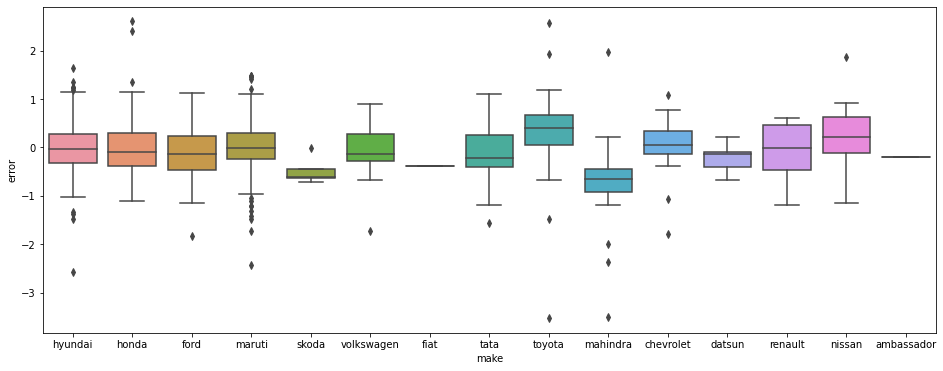

In [ ]:
plt.figure(figsize = (16, 6))
sn.boxplot( data = cars_df_prod,
            x = 'make',
            y = 'error',
            order = car_makes);

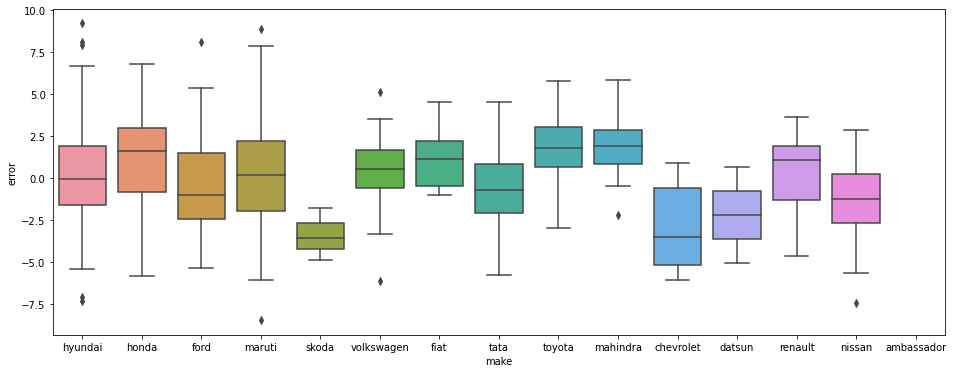

In [ ]:
plt.figure(figsize = (16, 6))
sn.boxplot( data = x_train,
            x = 'make',
            y = 'error',
            order = car_makes);

In [ ]:
error_by_make_location = pd.crosstab(cars_df_prod.make, cars_df_prod.Location, values = cars_df_prod.error, aggfunc = 'median' )

In [ ]:
error_by_make_location

Location,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune
make,,,,,,,,,,,
ambassador,NaN,NaN,-0.194561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chevrolet,NaN,NaN,0.312349,0.765063,-0.083956,-0.236328,0.356681,0.168901,0.035563,-1.072914,0.044936
datsun,NaN,-0.408578,NaN,NaN,NaN,-0.682382,NaN,NaN,-0.101900,NaN,NaN
fiat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.395802,-0.377295,NaN,NaN
ford,-0.334962,-0.041202,-0.303526,0.415444,0.329158,-0.186911,-0.800900,-0.545331,0.491474,-0.122527,-0.045079
honda,0.667762,NaN,0.074400,-0.300661,0.079569,0.300399,-0.313666,-0.212612,-0.246278,-0.029431,0.001028
hyundai,0.094362,-0.081213,-0.105923,0.025142,-0.051453,0.108640,0.102118,-0.288992,-0.142343,-0.103721,0.056616
mahindra,NaN,NaN,-0.652540,-0.759328,NaN,-1.045593,0.206724,-0.642366,NaN,-2.058483,-0.454044
maruti,-0.278485,-0.176520,-0.062289,0.329648,-0.130322,-0.022825,-0.029735,0.009647,0.092319,0.059084,-0.059468


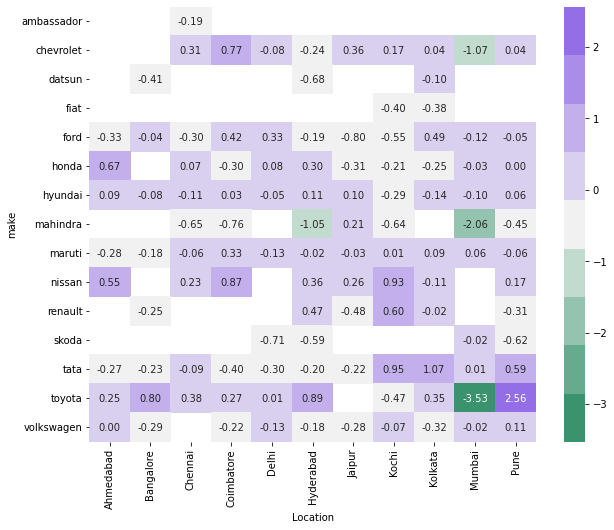

In [ ]:
plt.figure(figsize = (10, 8))
sn.heatmap(error_by_make_location, annot = True, fmt = "0.2f", cmap = sn.diverging_palette(150, 275, s=80, l=55, n=9));

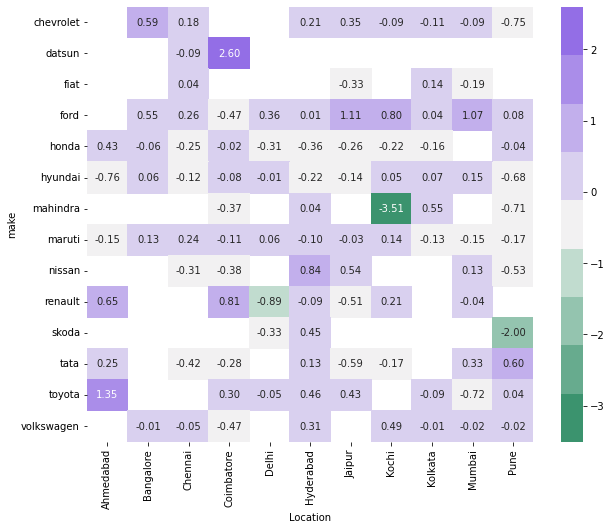

In [ ]:
train_error_by_make_location = pd.crosstab(x_train.make, x_train.Location, values = cars_df_prod.error, aggfunc = 'median' )
plt.figure(figsize = (10, 8))
sn.heatmap(train_error_by_make_location, annot = True, fmt = "0.2f", cmap = sn.diverging_palette(150, 275, s=80, l=55, n=9));